# Scenario 2 (High Density) [5 Repetitions]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

## Config

In [2]:
inputFile = '2kr-scalars-5rep.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

showConstructedDF = True

# Fitting
distsFit = ['norm', 'uniform'] # Distributions to fit
distsParams = [(), ()] # Distributions params
outlierStddevDistance = 3 # Outliers identification

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
scatterShowLines = False
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.activityTime:last']
# Residuals to compute
residualNames = [
    ('coveredUsersPercent', 'percentage of covered users (residuals)'),
    ('collisions', 'total number of collisions (residuals)'),
    ('activityTime', 'total broadcast time (residuals)'),
]

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

# Scatter plot whitelists
configsShown = range(0, configsCount)
repetitionsShown = range(0, repetitionsCount)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 5


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

## Compute residuals

In [6]:
# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)
scalars_wide['coveredUsersPercentMean'] = scalars_wide.groupby(factors)['coveredUsersPercent'].transform('mean')
scalars_wide['coveredUsersPercentResidual'] = scalars_wide['coveredUsersPercent'] - scalars_wide['coveredUsersPercentMean']

# collisions
scalars_wide['collisionsMean'] = scalars_wide.groupby(factors)['Floorplan.collisions:sum'].transform('mean')
scalars_wide['collisionsResidual'] = scalars_wide['Floorplan.collisions:sum'] - scalars_wide['collisionsMean']

# activity (broadcast) time
scalars_wide['activityTimeMean'] = scalars_wide.groupby(factors)['Floorplan.activityTime:last'].transform('mean')
scalars_wide['activityTimeResidual'] = scalars_wide['Floorplan.activityTime:last'] - scalars_wide['activityTimeMean']

## Constructed DataFrame

In [7]:
if showConstructedDF:
    display(scalars_wide.describe())
    display(scalars_wide[(totalSims//2)-10:(totalSims//2)+10])
else:
    print('Skipping...')

qname,config,repetition,R,T,m,D,Floorplan.userCount,Floorplan.coveredUsers:sum,Floorplan.collisions:sum,Floorplan.activityTime:last,coveredUsersPercent,coveredUsersPercentMean,coveredUsersPercentResidual,collisionsMean,collisionsResidual,activityTimeMean,activityTimeResidual
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.0,80.000000,80.000000,80.000000,80.000000,80.000000,8.000000e+01,80.000000,8.000000e+01,80.000000,8.000000e+01
mean,7.500000,2.000000,20.000000,3.000000,3.000000,3.000000,500.0,447.000000,882.487500,51.112500,0.895792,0.895792,-9.020562e-18,882.487500,-7.815970e-15,51.112500,1.199041e-15
std,4.638856,1.423136,10.063092,2.012618,2.012618,2.012618,0.0,57.544919,643.227345,42.019885,0.115320,0.084248,7.874722e-02,631.929815,1.200255e+02,39.785053,1.352110e+01
min,0.000000,0.000000,10.000000,1.000000,1.000000,1.000000,500.0,208.000000,70.000000,8.000000,0.416834,0.729860,-4.440882e-01,139.000000,-4.148000e+02,11.200000,-3.520000e+01
25%,3.750000,1.000000,10.000000,1.000000,1.000000,1.000000,500.0,426.500000,339.500000,19.250000,0.854709,0.851703,-1.082164e-02,332.500000,-3.500000e+01,25.700000,-3.950000e+00
50%,7.500000,2.000000,20.000000,3.000000,3.000000,3.000000,500.0,456.000000,656.500000,35.500000,0.913828,0.885972,1.803607e-03,672.300000,-3.000000e-01,35.500000,-5.000000e-01
75%,11.250000,3.000000,30.000000,5.000000,5.000000,5.000000,500.0,492.250000,1350.000000,68.250000,0.986473,0.970842,2.064128e-02,1322.600000,3.105000e+01,68.300000,2.650000e+00
max,15.000000,4.000000,30.000000,5.000000,5.000000,5.000000,500.0,499.000000,2463.000000,232.000000,1.000000,1.000000,1.879760e-01,2024.800000,4.896000e+02,147.200000,8.480000e+01


qname,config,repetition,R,T,m,D,Floorplan.userCount,Floorplan.coveredUsers:sum,Floorplan.collisions:sum,Floorplan.activityTime:last,coveredUsersPercent,coveredUsersPercentMean,coveredUsersPercentResidual,collisionsMean,collisionsResidual,activityTimeMean,activityTimeResidual
run,,,,,,,,,,,,,,,,,
HighDensity2kr-50-20210202-13:16:29-14927,6.0,0.0,10.0,5.0,5.0,1.0,500.0,494.0,697.0,96.0,0.989980,0.991583,-0.001603,637.0,60.0,96.8,-0.8
HighDensity2kr-51-20210202-13:16:30-14927,6.0,1.0,10.0,5.0,5.0,1.0,500.0,495.0,618.0,78.0,0.991984,0.991583,0.000401,637.0,-19.0,96.8,-18.8
HighDensity2kr-52-20210202-13:16:30-14927,6.0,2.0,10.0,5.0,5.0,1.0,500.0,496.0,577.0,96.0,0.993988,0.991583,0.002405,637.0,-60.0,96.8,-0.8
HighDensity2kr-53-20210202-13:16:31-14927,6.0,3.0,10.0,5.0,5.0,1.0,500.0,493.0,655.0,103.0,0.987976,0.991583,-0.003607,637.0,18.0,96.8,6.2
HighDensity2kr-54-20210202-13:16:31-14927,6.0,4.0,10.0,5.0,5.0,1.0,500.0,496.0,638.0,111.0,0.993988,0.991583,0.002405,637.0,1.0,96.8,14.2
HighDensity2kr-70-20210202-13:16:34-14927,7.0,0.0,10.0,5.0,5.0,5.0,500.0,499.0,407.0,102.0,1.000000,1.000000,0.000000,418.8,-11.8,103.0,-1.0
HighDensity2kr-71-20210202-13:16:35-14927,7.0,1.0,10.0,5.0,5.0,5.0,500.0,499.0,406.0,113.0,1.000000,1.000000,0.000000,418.8,-12.8,103.0,10.0
HighDensity2kr-72-20210202-13:16:35-14927,7.0,2.0,10.0,5.0,5.0,5.0,500.0,499.0,445.0,97.0,1.000000,1.000000,0.000000,418.8,26.2,103.0,-6.0
HighDensity2kr-73-20210202-13:16:35-14927,7.0,3.0,10.0,5.0,5.0,5.0,500.0,499.0,416.0,92.0,1.000000,1.000000,0.000000,418.8,-2.8,103.0,-11.0


## Residual distributions (histograms)

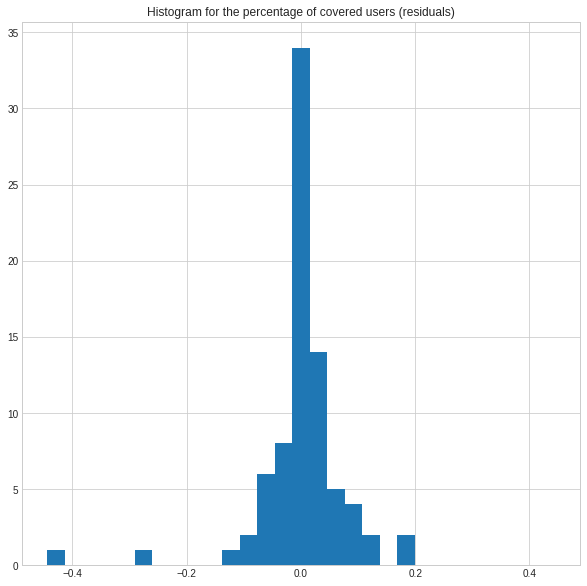

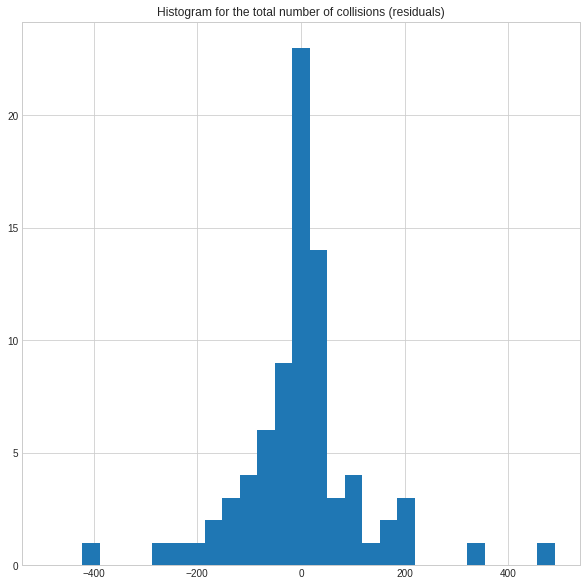

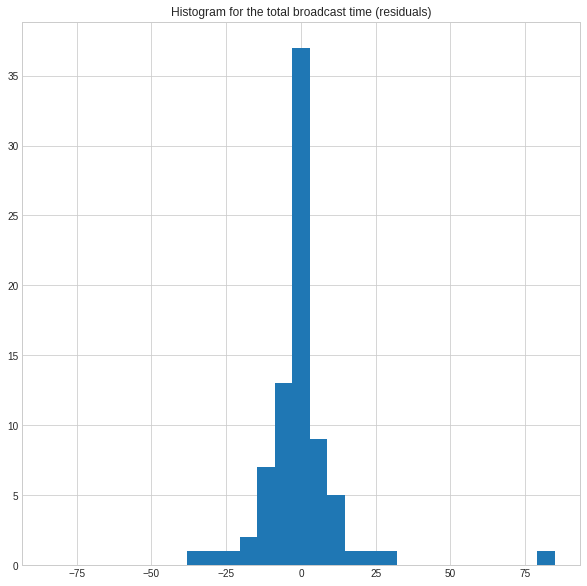

In [8]:
for varname, vardesc in residualNames:
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    minval = scalars_wide[varname + 'Residual'].min()
    maxval = scalars_wide[varname + 'Residual'].max()
    if histCenter:
        limit = max(abs(minval), abs(maxval))
        minval = -limit
        maxval = limit
    plt.hist(scalars_wide[varname + 'Residual'].values.tolist(), bins=np.linspace(minval, maxval, histBinNum))
    plt.title('Histogram for the ' + vardesc)
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-hist.png')
    plt.show()

## Distribution fitting

Trying to fit to a norm distribution:


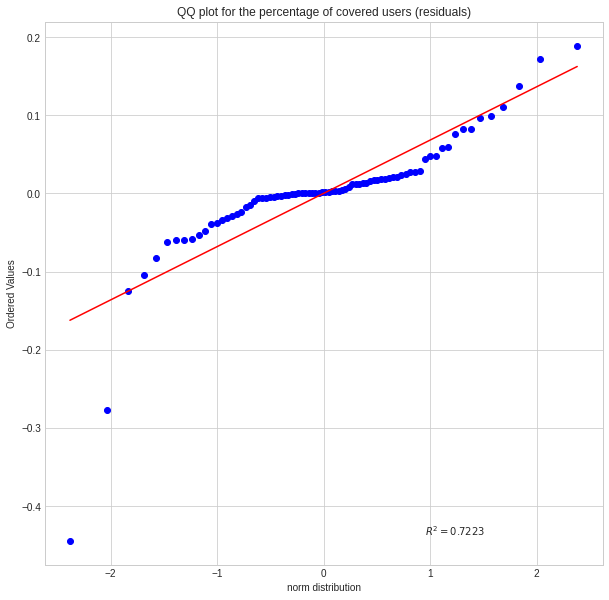

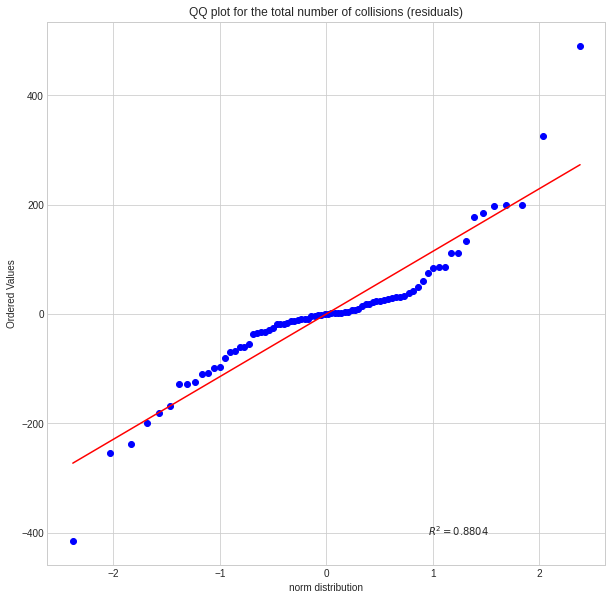

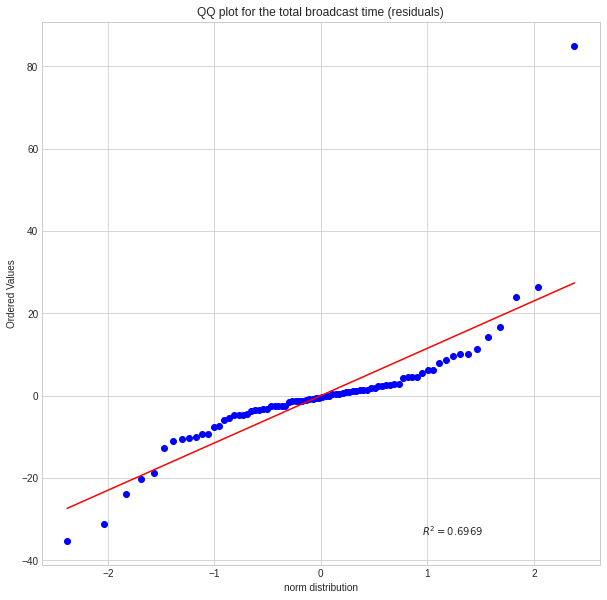

Trying to fit to a uniform distribution:


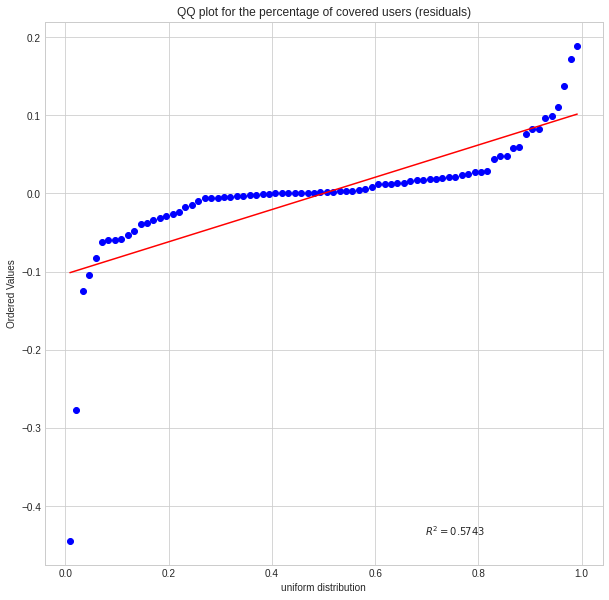

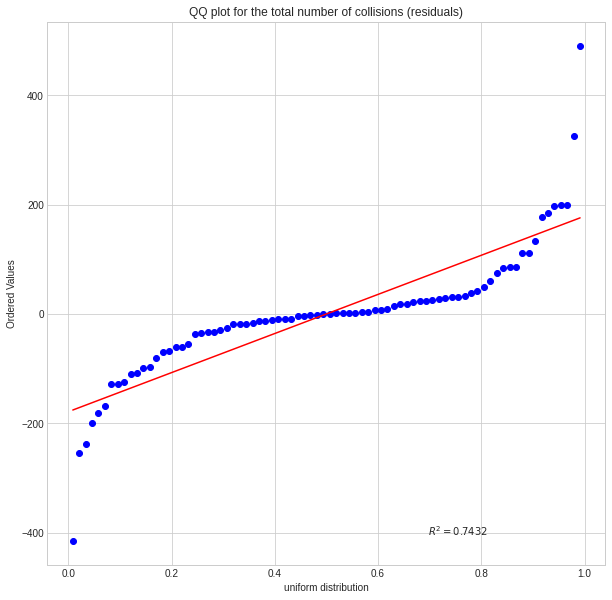

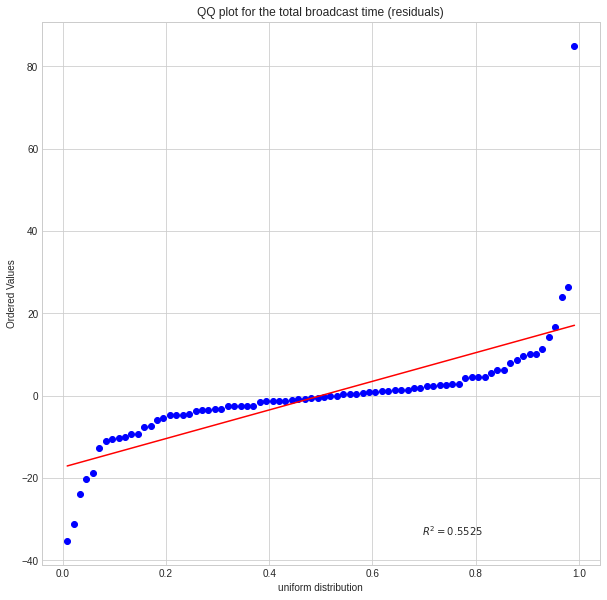

In [9]:
for distribution, params in zip(distsFit, distsParams):
    print('Trying to fit to a', distribution + ('({})'.format(', '.join(map(str, params))) if len(params) > 0 else ''), 'distribution:')
    for varname, vardesc in residualNames:
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        residuals = scalars_wide[varname + 'Residual'].values.tolist()
        result, line = stats.probplot(residuals, dist=distribution, sparams=params, plot=plt, rvalue=True)
        #osm, _ = result
        #slope, intercept, _ = line
        plt.title("QQ plot for the " + vardesc)
        plt.xlabel(distribution + " distribution")
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + varname + '-' + distribution + '-fit.png')
        plt.show()

### Outliers

In [10]:
for varname, vardesc in residualNames:
    print('Outliers for the ' + vardesc)
    stddev = scalars_wide[varname + 'Residual'].std()
    limit = outlierStddevDistance*stddev
    print('total mean:', scalars_wide[varname + 'Mean'].mean())
    print('stddev:', stddev)
    print(str(outlierStddevDistance) + '*stddev:', limit)
    outliers = scalars_wide[np.abs(scalars_wide[varname + 'Residual']) > limit]
    display(outliers[['config', 'repetition', *factors, varname + 'Residual', varname + 'Mean']])

Outliers for the percentage of covered users (residuals)
total mean: 0.8957915831663323
stddev: 0.07874721579384643
3*stddev: 0.2362416473815393


qname,config,repetition,R,T,m,D,coveredUsersPercentResidual,coveredUsersPercentMean
run,,,,,,,,
HighDensity2kr-64-20210202-13:16:33-14927,5.0,4.0,10.0,5.0,1.0,5.0,-0.444088,0.860922
HighDensity2kr-7-20210202-13:16:18-14927,8.0,2.0,30.0,1.0,1.0,1.0,-0.276553,0.751503


Outliers for the total number of collisions (residuals)
total mean: 882.4875000000005
stddev: 120.0255247115316
3*stddev: 360.0765741345948


qname,config,repetition,R,T,m,D,collisionsResidual,collisionsMean
run,,,,,,,,
HighDensity2kr-36-20210202-13:16:27-14927,11.0,1.0,30.0,1.0,5.0,5.0,489.6,1973.4
HighDensity2kr-58-20210202-13:16:32-14927,14.0,3.0,30.0,5.0,5.0,1.0,-414.8,1686.8


Outliers for the total broadcast time (residuals)
total mean: 51.11249999999997
stddev: 13.521103992076863
3*stddev: 40.563311976230594


qname,config,repetition,R,T,m,D,activityTimeResidual,activityTimeMean
run,,,,,,,,
HighDensity2kr-60-20210202-13:16:33-14927,5.0,0.0,10.0,5.0,1.0,5.0,84.8,147.2


## Independency test

qname,config,R,T,m,D
run,,,,,
HighDensity2kr-0-20210202-13:16:17-14927,0.0,10.0,1.0,1.0,1.0
HighDensity2kr-20-20210202-13:16:22-14927,1.0,10.0,1.0,1.0,5.0
HighDensity2kr-10-20210202-13:16:19-14927,2.0,10.0,1.0,5.0,1.0
HighDensity2kr-30-20210202-13:16:24-14927,3.0,10.0,1.0,5.0,5.0
HighDensity2kr-40-20210202-13:16:28-14927,4.0,10.0,5.0,1.0,1.0
HighDensity2kr-60-20210202-13:16:33-14927,5.0,10.0,5.0,1.0,5.0
HighDensity2kr-50-20210202-13:16:29-14927,6.0,10.0,5.0,5.0,1.0
HighDensity2kr-70-20210202-13:16:34-14927,7.0,10.0,5.0,5.0,5.0
HighDensity2kr-5-20210202-13:16:18-14927,8.0,30.0,1.0,1.0,1.0


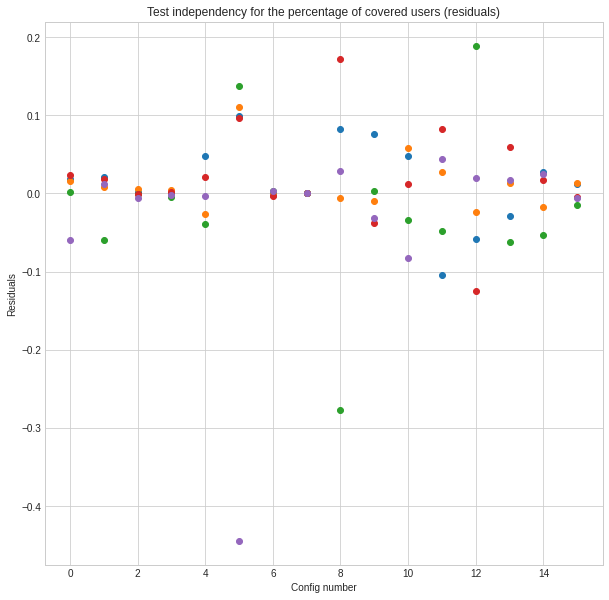

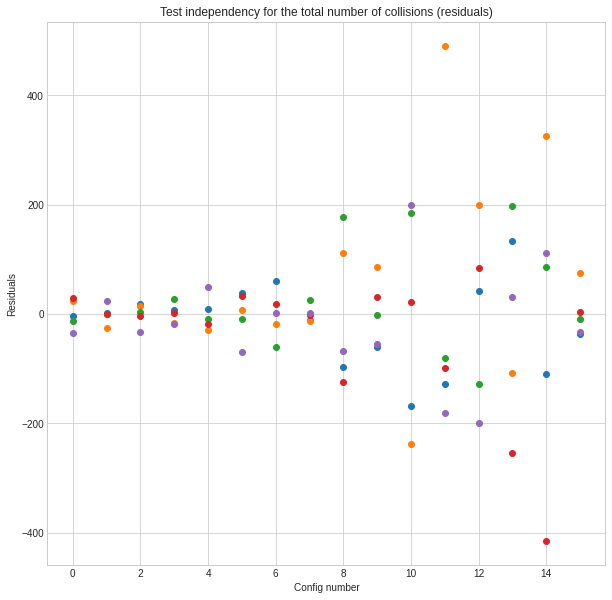

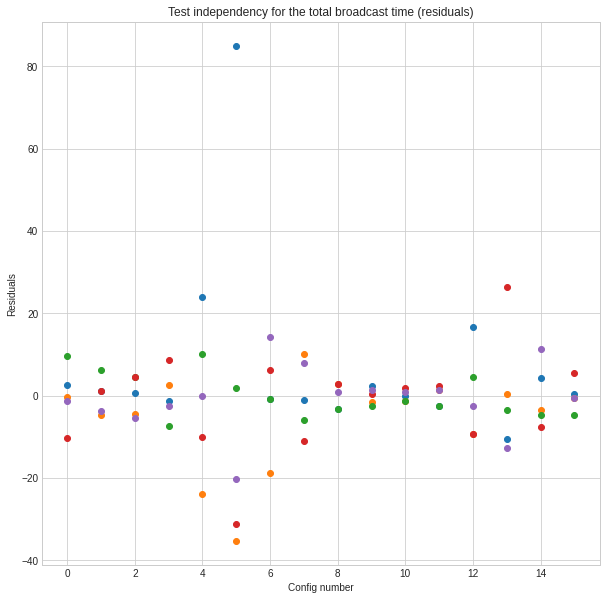

In [11]:
display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config.isin(configsShown))][['config', *factors]])
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append([config] * len(repetitionsShown))
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test independency for the " + vardesc)
    plt.xlabel("Config number")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-independency.png')
    plt.show()

## Finite variance test

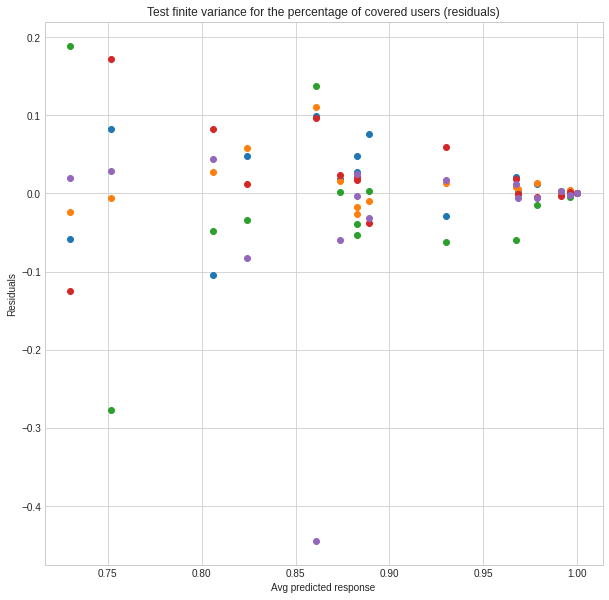

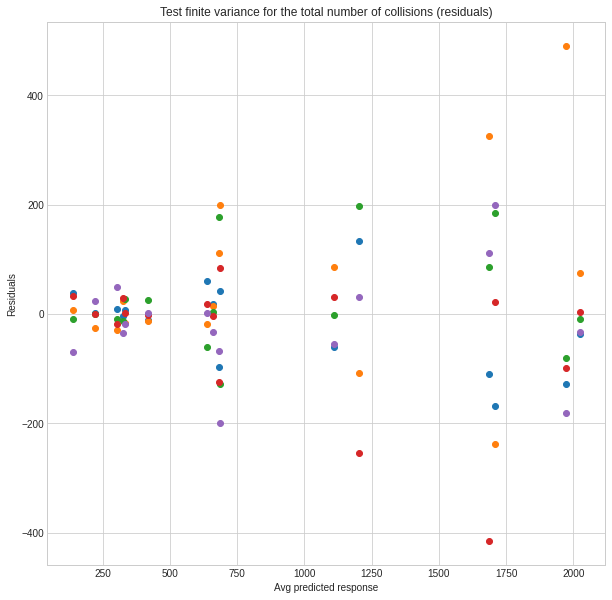

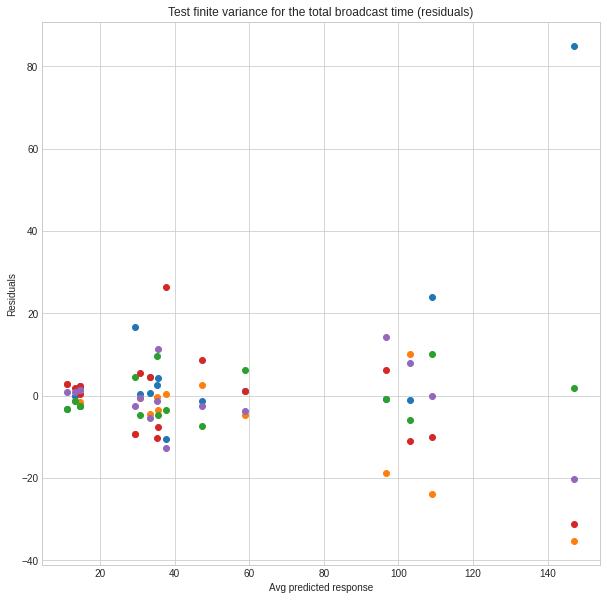

In [12]:
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Mean'].values.tolist())
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test finite variance for the " + vardesc)
    plt.xlabel("Avg predicted response")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-variance.png')
    plt.show()